# <center> **DSCI 100 Project: Predicting Usage of a Video Game Server**
# <center> **Final Report**

## Introduction

- Do we need to include, mention and describe the other dataset if we are not going to use it?  Also do we need to include the broad question(s)?
- Check if it is okay to have a paragraph and not written embedded with code?
- Does my table have to be for all variables or just those of interest?

A group of Computer Science students, led by Frank Wong, at UBC created a Minecraft server and recorded player demographics and play sessions data in two data frames.  The goal of their study was to learn how people play video games and determine ways to target recruitment efforts and have enough resources, such as softwware licences, in order to manage the number of users on their server.

This project report aims to answer a specific question within one of their broader question of interest: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"  The specific question that this project intends to answer is: 'Can age and amount of time playing video games predict whether or not a player has subscribed to the Minecraft newsletter in the players dataset?'  This question asks to predict the main categorical variable (`subscribe`) in the dataset of which there are two groups: "TRUE" and "FALSE".  Thus, it is a classification problem and K-nearest neighbours will be used in this analysis.

The dataset of player demographics is used to answer the question to help better understand the player characteristics that are predictive of subscribing to a gaming newsletter.  There are 7 variables and 196 observations of the dataset.  The dataset consists of data for MineCraft video game players of different ages with varying levels of experience in gaming and number of hours played (dbl). The logistics of their name (chr), gender (chr), age (dbl), email (chr), experience (chr) and whether they have subscribed to the newsletter (lgl) are included. 

A potential issue with the dataset is that the `subscribe` variable is logical type but should be factor type in order to treat it as a categorical variable for classification.  This column also contains far more 'true' than 'false' categories which may create an imbalanace in the data and affect the K-nearest neighbours algorithm.  Note that the additional variables such as  `gender` or `experience` are not used as predictor variables in the analysis and therefore can be removed in the data wrangling step.





Outcome Variable: The main outcome/categorical/label variable in the dataset is the 'subscribe' variable which describes whether or not a player has subscribed to the Minecraft newsletter. Thus, there are two groups within the category: "TRUE" or "FALSE". We can double check using the distinct function below.

Load themis package to upsample the data.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis) # To upsample the data
options(repr.matrix.max.rows = 6)
set.seed(1) # For reproducibility

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_orig <- read_csv("players.csv")
players_orig

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [14]:
# Check the categories under the "subscribe" variable
players_orig |>
    distinct(subscribe)

# Determine the number of observations in each category of "True" and "False"
num_subscribe <- players_orig |>
    group_by(subscribe) |>
    summarize(count = n())
num_subscribe

# Calculate summary statistics for variables in the dataset
stats_players <- players_orig |>
    summarize(mean_age = mean(Age, na.rm = TRUE), min_age = min(Age, na.rm = TRUE), max_age = max(Age, na.rm = TRUE),
             mean_hours = mean(played_hours), min_hours = min(played_hours), max_hours = max(played_hours))
stats_players

# Try to put summary statistics in one cell.  Don't print them yet.  Create a table (1 cell) for those results (ideally in one cell).

subscribe
<lgl>
TRUE
FALSE


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


mean_age,min_age,max_age,mean_hours,min_hours,max_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,8,50,5.845918,0,223.1


In [26]:
stats_table <- data.frame(
    Statistic = c("Data Type", "Mean", "Min", "Max"),
    Age = c("Double", 20.52, 8, 50),
    Hours = c("Double", 5.85, 0, 233.1),
    Subscribe = c("Logical", NA, NA, NA), 
    Experience = c("Character", NA, NA, NA),
    Name = c("Character", NA, NA, NA), 
    Gender = c("Character", NA, NA, NA) 
)
stats_table

Statistic,Age,Hours,Subscribe,Experience,Name,Gender
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Data Type,Double,Double,Logical,Character,Character,Character
Mean,20.52,5.85,NA,NA,NA,NA
Min,8,0,NA,NA,NA,NA
Max,50,233.1,NA,NA,NA,NA


## Methods

### Clean and Wrangle the Data
Select the hashedEmail (to keep the identification of individual players), Age, played_hours and subscribe columns, and convert `subscribe` as a categorical variable, so I convert it into a factor type variable using the `as_factor()` function.

In [5]:
players <- players_orig |>
    mutate(subscribe = as_factor(subscribe)) |>
    select(hashedEmail, Age, played_hours, subscribe)
players

hashedEmail,Age,played_hours,subscribe
<chr>,<dbl>,<dbl>,<fct>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9,30.3,TRUE
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17,3.8,TRUE
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17,0.0,FALSE
⋮,⋮,⋮,⋮
d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,17,0.0,FALSE
f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17,2.3,FALSE
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,NA,0.2,TRUE


**Introduction Instructions: "performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis" - ?**

### Create a Visualization for Exploratory Analysis

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


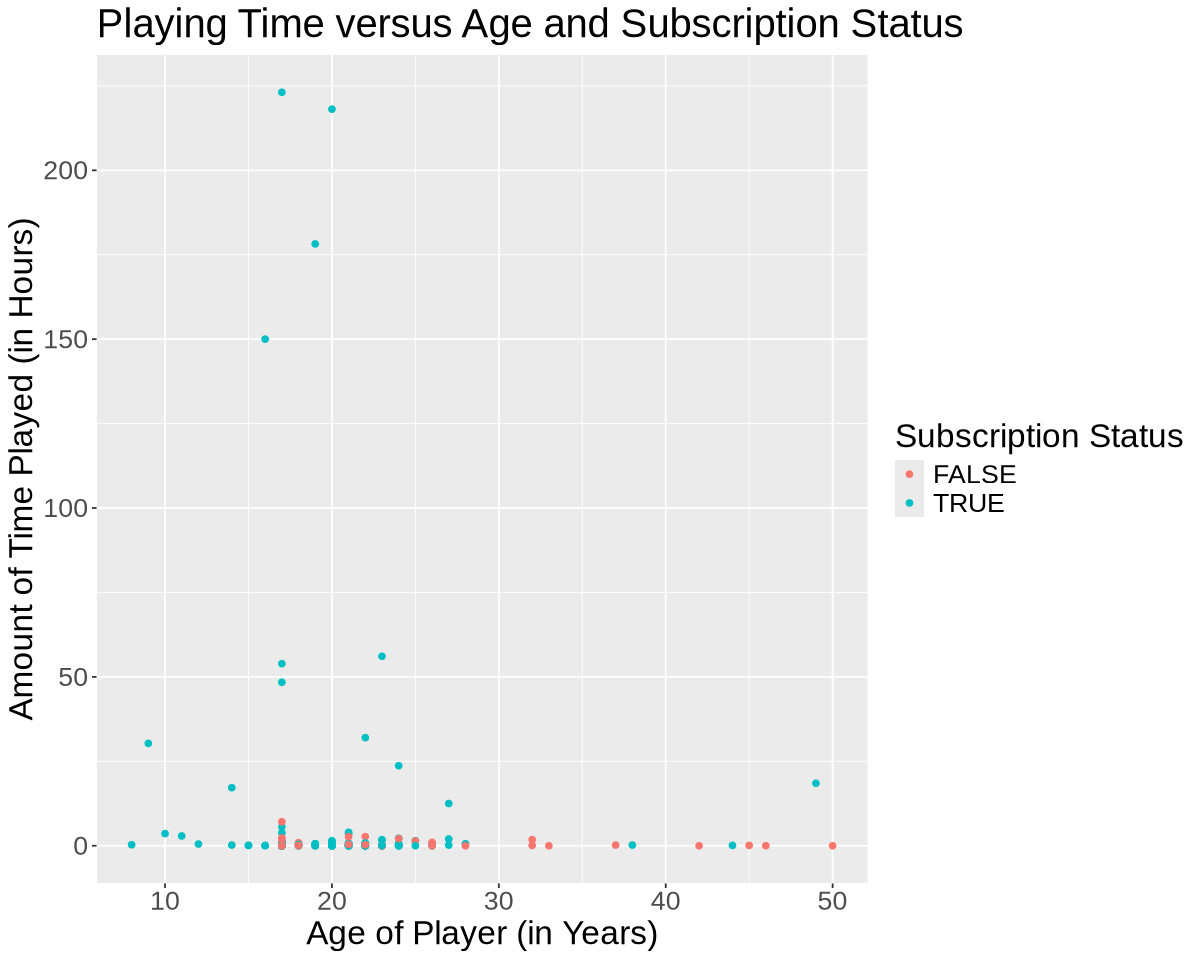

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8)
players_scatter <- players |>
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(aes(color = subscribe)) +
        xlab("Age of Player (in Years)") +
        ylab("Amount of Time Played (in Hours)") +
        labs(color = "Subscription Status", title = "Playing Time versus Age and Subscription Status") +
        theme(text = element_text(size = 20))
players_scatter

Uncomparable scales and more TRUE than FALSE as shown in intro too.  Need to upsample.

In [7]:
ups_recipe <- recipe(subscribe ~ Age + played_hours, data = players) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
    prep() |>
    bake(players)
ups_recipe

# ups_players <- bake(ups_recipe, players)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
21,0.0,FALSE
37,0.2,FALSE
24,0.0,FALSE
⋮,⋮,⋮
20,0.0,TRUE
17,0.0,TRUE
NA,0.2,TRUE


In [8]:
players_split <- initial_split(ups_players, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

ERROR: Error in eval(expr, envir, enclos): object 'ups_players' not found


gridvals has 1 to 10 because k nearest neighbours estimate of possible values (just guessed)

In [ ]:
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())
players_recipe

players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Perform 5-fold cross-validation
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

players_knn_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec)

gridvals <- tibble(neighbors = seq(1, 10, by = 1))

players_knn_results <- players_knn_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

# Select the k value that results in the best RMSE (lowest RMSE)
kmin <- players_knn_results |>
    filter(.metric == "rmse")
    # filter(mean == min(mean)) 
    # pull(neighbors)
kmin
    
# # Retrain the model on the training data using the best k value
# players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# players_fit <- workflow() |>
#     add_recipe(players_recipe) |>
#     add_model(players_spec) |>
#     fit(data = players_training)

# knn_rmspe <- players_fit |>
#     predict(players_testing) |>
#     bind_cols(players_testing) |>
#     metrics(truth = subscribe, estimate = .pred) |>
#     filter(.metric == "rmse") |>
#     pull(.estimate)
# knn_rmspe

## Results

## Discussion

## References